In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import ttest_ind
from numpy import median
from glob import glob

In [2]:
fun_df = pd.read_csv("data/func_class_p0.05_effectsize2.0.csv")
display(len(fun_df))

# only look at correct constructs
fun_df = fun_df[(fun_df['correct'] == True)]
# Remove seq12 which did not have any constructs
fun_df = fun_df[fun_df['seqID'] != 'seq12']

# only need one example of each run_id
temp_df = pd.DataFrame()
run_ids = list(set(fun_df['run_id'].values))
for run_id in run_ids:
    t_df = fun_df[fun_df['run_id'] == run_id]
    temp_df = temp_df.append(t_df.iloc[0], sort=False)
    
fun_df = temp_df

1353

In [3]:
gen_df = temp_df[~temp_df['family'].isin(['positive','negative'])]
display(set(gen_df['family'].values))
gen_df

{'amylase', 'lipase', 'protease', 'xylanase'}

,Unnamed: 0,assay,assay_value,correct,family,func,old_correct,plot_id,prot_correct,protein_id,run_id,run_index,run_label,seqID,sp_correct,sp_id
1075,1075.0,assay_2_value,2.72200,1.0,xylanase,1.0,True,NaN,1.0,Arnold_040,26_40-1,538.0,xylanase_1,seq26,1.0,sps40-1
595,595.0,assay_1_value,0.21200,1.0,amylase,0.0,True,Pro_01-2,1.0,Arnold_004,5_18-2,136.0,amylase_2,seq5,1.0,sps18-2
475,475.0,assay_1_value,0.34000,1.0,amylase,0.0,True,Pro_04-3,1.0,Arnold_001,39_20-3,51.0,amylase_1,seq39,1.0,sps20-3
519,519.0,assay_4_value,0.32400,1.0,amylase,1.0,True,NaN,1.0,Arnold_004,5_15-3,117.0,amylase_2,seq5,1.0,sps15-3
876,876.0,assay_3_value,2.28744,1.0,protease,0.0,True,NaN,1.0,Arnold_036,1_15-3,417.0,protease_1,seq1,1.0,sps15-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,827.0,assay_3_value,3.06282,1.0,protease,1.0,True,NaN,1.0,Arnold_036,1_22-2,399.0,protease_1,seq1,1.0,sps22-2
934,934.0,assay_1_value,0.18114,1.0,protease,0.0,True,Pro_02-2,1.0,Arnold_034,36_12-2,469.0,protease_1,seq36,1.0,sps12-2
500,500.0,assay_3_value,0.46600,1.0,amylase,0.0,True,NaN,1.0,Arnold_001,39_39-2,8.0,amylase_1,seq39,1.0,sps39-2
1287,1287.0,assay_3_value,1.25600,1.0,xylanase,0.0,True,NaN,1.0,Arnold_039,3_3-1,561.0,xylanase_1,seq3,1.0,sps3-1


In [4]:
# Summary stats

In [5]:
_df = fun_df[fun_df['family'] == 'positive']
total = sum([len(_df[_df['func']==1]), len(_df[_df['func']==0])])
print(len(_df[_df['func']==1]), "constructs functional\n" , len(_df[_df['func']==0]), "constructs not\n", total)

27 constructs functional
 7 constructs not
 34


In [6]:
_df = fun_df[~fun_df['family'].isin(['positive','negative'])]
total = sum([len(_df[_df['func']==1]), len(_df[_df['func']==0])])
print(len(_df[_df['func']==1]), "constructs functional\n" , len(_df[_df['func']==0]), "constructs not\n", total)
constructs_df = _df

53 constructs functional
 58 constructs not
 111


In [7]:
# Read in signalp data

sp_df = pd.DataFrame()
for f in glob("data/signalp_stats/*.txt"):
    _df = pd.read_csv(f, sep="\t", header=1)
    sp_df = sp_df.append(_df, sort=False)
display(len(sp_df))

# Remove non-GA constructs (original predictions that didn't have the true GA ending needed for cloning)
sp_df['GA'] = sp_df.apply(lambda x: True if x["# ID"][-2:]=="ga" else False, axis=1)
sp_df_predicted = sp_df[sp_df['GA'] == False]
sp_df = sp_df[sp_df['GA'] == True]

# Add run_id to match fun_df
def run2fun(row):
    comps = row['# ID'].split("_")
    run_id = comps[4] + "_" + comps[1] + "-" + comps[2]
    return run_id
sp_df['run_id'] = sp_df.apply(lambda x: run2fun(x), axis=1)

# Just look at overall probabilities for now
sp_df['prob'] = 1 - sp_df['OTHER']
fun_df = fun_df[fun_df['family'] != 'positive']
df = fun_df.merge(sp_df, on="run_id").sort_values(by="prob")
func_cons_df = df
# df['class_plot'] = df.apply(lambda x: 0 if x['class']=="nonfunctional" else 1, axis=1)

111

In [8]:
func_cons_df

,Unnamed: 0,assay,assay_value,correct,family,func,old_correct,plot_id,prot_correct,protein_id,...,sp_id,# ID,Prediction,SP(Sec/SPI),TAT(Tat/SPI),LIPO(Sec/SPII),OTHER,CS Position,GA,prob
48,254.0,assay_4_value,0.13800,1.0,amylase,0.0,True,NaN,1.0,Arnold_003,...,sps33-1,sp_33_1_prot_33_ga,OTHER,0.011738,0.001768,0.001774,0.984719,NaN,True,0.015281
63,147.0,assay_2_value,0.34600,1.0,amylase,0.0,True,NaN,1.0,Arnold_015,...,sps24-3,sp_24_3_prot_21_ga,OTHER,0.169062,0.002067,0.032688,0.796183,NaN,True,0.203817
43,95.0,assay_4_value,1.19600,1.0,amylase,1.0,False (-SP/+Protein),NaN,1.0,Arnold_015,...,sps24-4,sp_24_4_prot_21_ga,OTHER,0.229497,0.002131,0.057309,0.711063,NaN,True,0.288937
26,429.0,assay_1_value,0.35000,1.0,amylase,0.0,True,Pro_02-2,1.0,Arnold_001,...,sps12-2,sp_12_2_prot_39_ga,OTHER,0.115341,0.006321,0.323075,0.555262,NaN,True,0.444738
6,0.0,assay_3_value,0.50200,1.0,amylase,1.0,True,NaN,1.0,Arnold_002,...,sps12-2,sp_12_2_prot_19_ga,OTHER,0.144268,0.002467,0.399141,0.454124,NaN,True,0.545876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,258.0,assay_4_value,0.34800,1.0,amylase,0.0,True,NaN,1.0,Arnold_003,...,sps33-2,sp_33_2_prot_33_ga,LIPO(Sec/SPII),0.442475,0.009517,0.547412,0.000595,CS pos: 18-19. AAG-CG. Pr: 0.5510,True,0.999405
84,1050.0,assay_4_value,4.49800,1.0,xylanase,1.0,True,NaN,1.0,Arnold_040,...,sps26-2,sp_26_2_prot_26_ga,SP(Sec/SPI),0.969920,0.000231,0.029331,0.000518,CS pos: 19-20. AQA-AT. Pr: 0.8226,True,0.999482
91,515.0,assay_4_value,1.57600,1.0,amylase,1.0,True,NaN,1.0,Arnold_004,...,sps13-3,sp_13_3_prot_5_ga,SP(Sec/SPI),0.997570,0.001009,0.001121,0.000300,CS pos: 26-27. AHA-ET. Pr: 0.9319,True,0.999700
83,679.0,assay_2_value,0.29232,1.0,lipase,1.0,True,NaN,1.0,Arnold_026,...,sps25-2,sp_25_2_prot_25_ga,LIPO(Sec/SPII),0.002732,0.000205,0.996805,0.000258,CS pos: 17-18. VAG-CS. Pr: 0.9979,True,0.999742


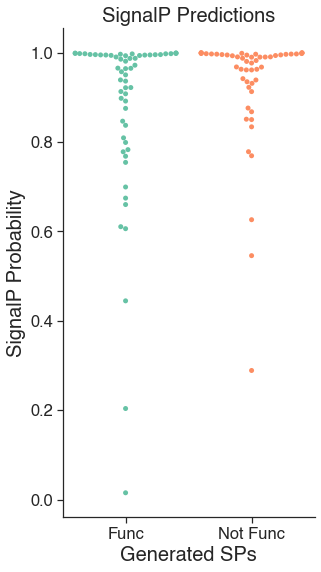

In [14]:
sns.set(font='helvetica', context='notebook', font_scale=1.5, style='ticks')
df['func_str'] = ['Func' if func==0 else 'Not Func' for func in df['func'].values]
# sns.set_palette(sns.color_palette("Set3"))
fig = plt.figure(figsize=(5,9))
plt.tight_layout()
plt.gcf().subplots_adjust(left=0.2)
g = sns.swarmplot(x="func_str", y="prob", data=df, palette=sns.color_palette("Set2"))

plt.ylabel('SignalP Probability', fontsize=20)
plt.xlabel('Generated SPs', fontsize=20)
plt.title('SignalP Predictions', fontsize=20)
sns.despine()
plt.savefig('data/figs/signalp_swarm.svg')
# g.set(xlim=(-0.1,1.1), ylim=(-0.1,1.1))

### Make ROC Curve

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(func_cons_df['func'].values, func_cons_df['prob'].values, pos_label=1)
roc_auc = auc(fpr, tpr)

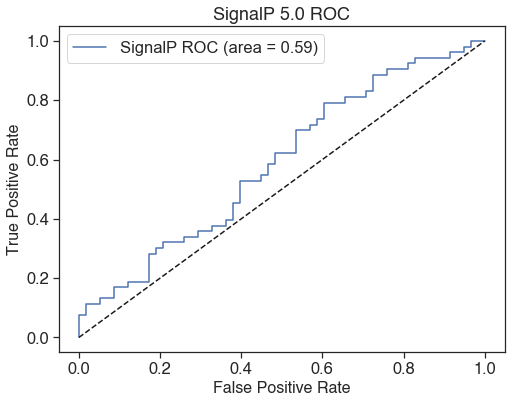

In [10]:
sns.set(font='helvetica', context='notebook', font_scale=1.5, style='ticks')

# sns.set_palette(sns.color_palette("Set3"))
fig = plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='SignalP ROC (area = %0.2f)' % roc_auc) #
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('SignalP 5.0 ROC', fontsize=18)

plt.legend(loc="best", prop={'size': 14})
L = plt.legend()
plt.setp(L.texts, family='Arial')

plt.savefig('data/figs/signalp_roc.svg')
plt.show()
# print('\n--\n')

# Look at transferability

In [48]:
df_trunc = df[['sp_id', 'func']]
df_trunc

,sp_id,func
48,sps33-1,0.0
63,sps24-3,0.0
43,sps24-4,1.0
26,sps12-2,0.0
6,sps12-2,1.0
...,...,...
55,sps33-2,0.0
84,sps26-2,1.0
91,sps13-3,1.0
83,sps25-2,1.0


In [54]:
sps = list(set(df_trunc['sp_id'].values))

ls = []
multi_df = pd.DataFrame()
sums = []
c = 0
for sp in sps:
    _df = df[df['sp_id']==sp]
    l = len(_df)
    funcs = _df['func'].values
    if l != 1:
        c += 1
        ls.append(l-1)
        fraction_functional = np.sum(funcs)/len(funcs)
        sums.append(fraction_functional)
        print(sp, '  \t', l, '\t', fraction_functional)
        multi_df = multi_df.append(_df)
assert np.sum(ls) + len(sps) == len(df)
print(c)

sps19-1   	 2 	 0.5
sps13-3   	 3 	 1.0
sps18-2   	 3 	 0.6666666666666666
sps24-2   	 2 	 0.0
sps12-2   	 4 	 0.25
sps12-3   	 3 	 0.0
sps39-4   	 2 	 1.0
sps18-1   	 2 	 0.0
sps21-1   	 2 	 0.5
sps9-3   	 2 	 0.0
sps3-1   	 2 	 0.5
sps24-4   	 2 	 1.0
sps21-2   	 2 	 1.0
sps21-3   	 2 	 0.5
sps39-2   	 2 	 0.0
sps15-3   	 2 	 0.5
sps12-4   	 3 	 0.6666666666666666
sps19-3   	 3 	 0.3333333333333333
sps19-2   	 2 	 0.5
sps19-4   	 3 	 0.6666666666666666
sps3-4   	 2 	 0.0
sps18-4   	 2 	 0.5
sps21-4   	 3 	 1.0
sps9-2   	 2 	 0.5
sps24-3   	 2 	 0.5
sps18-3   	 2 	 0.5
sps12-1   	 4 	 0.25
27


In [68]:
import pickle

In [69]:
sps.sort()
new_sp_plot_dict = {k:f"Gen{i:03d}" for i,k in enumerate(sps)}
pickle.dump(new_sp_plot_dict, open('data/final_sp_plot_dict.p','wb'))

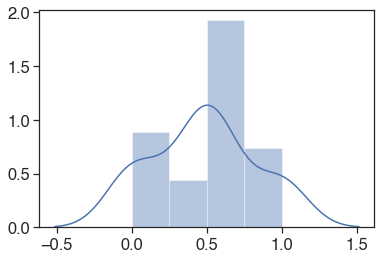

In [50]:
sns.distplot(sums)

In [52]:
print(np.average(sums), np.std(sums))

0.4753086419753086 0.3316429475472479


In [57]:
print(np.sum(multi_df['func'].values), len(multi_df))

31.0 65


In [ ]:
# Most SPs tested multiple times are only functional once out of twice, but this agrees with 48% overall success rate